In [1]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam, SGD
from keras import backend as Keras

Using TensorFlow backend.


In [2]:
import sys
sys.path.insert(0, '/home/albert/github/DenseNet/')
import densenet

### Mine Triplets

In [3]:
CAFFE_ROOT = '/home/albert/caffe/'
img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')

In [4]:
train_files = {}
train_arr = []
labels = []

for f in img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in labels):
            labels.append(idt)
            train_files[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files[idt].append(path)
        train_arr.append([path, idt])

labels.sort()

### Train Network

In [5]:
# Number of identities
P_param = 18
# Number of images per identity
K_param = 4

In [6]:
def preprocess(img):
    VGG_MEAN = [103.939, 116.779, 123.68]
    out = np.copy(img) * 255
    out = out[:, :, [2,1,0]] # swap channel from RGB to BGR
    out[:,:,0] -= VGG_MEAN[0]
    out[:,:,1] -= VGG_MEAN[1]
    out[:,:,2] -= VGG_MEAN[2]
    return out

In [7]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.125,
        horizontal_flip=True,
        fill_mode='nearest')

In [8]:
def output_batch_generator(train_files, labels, P=P_param, K=K_param):
    while True:
        batch = []
        idt_choice = np.random.choice(labels, P, replace=False)
        for p in range(len(idt_choice)):
            if K > len(train_files[idt_choice[p]]):
                k_choice = np.random.choice(range(len(train_files[idt_choice[p]])), K, replace=True)
            else:
                k_choice = np.random.choice(range(len(train_files[idt_choice[p]])), K, replace=False)
            for k in k_choice:
                path = train_files[idt_choice[p]][k]
                img = misc.imread(path).astype(np.float64)
                batch.append(img.tolist())
        output = np.array(batch)
        yield(output, np.zeros((P*K, 128)))

In [9]:
def log1p(x):
    return Keras.log(1 + Keras.exp(x))

In [10]:
def dist(x1, x2):
    return Keras.sum(Keras.abs(x1 - x2))

In [11]:
def triplet_loss(y_true, y_pred, margin=0.5, P=P_param, K=K_param, output_dim = 128):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))

    loss = tf.Variable(1, dtype=tf.float32)

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                      embeddings[(i + 1)*K:]], 0)))
            loss += margin + hard_pos - hard_neg
    return loss

In [12]:
def evaluate_rank(net, rank, all_embeddings, all_identities, test_iter=1000):
    correct = 0
    f_choice = np.random.choice(range(len(train_arr)), np.minimum(test_iter, len(train_arr)), replace=False)
    for f in f_choice:
        query_img = misc.imread(train_arr[f][0])
        query_embedding = net.predict(query_img.reshape(1, 128, 64, 3))
        distance_vectors = np.squeeze(np.abs(all_embeddings - query_embedding))
        distance = np.sum(distance_vectors, axis=1)
        top_inds = distance.argsort()[:rank+1]
        output_classes = np.array(all_identities)[top_inds].astype(np.uint16)
        
#         pp.pprint(zip(distance[top_inds], np.array(all_identities)[top_inds].astype(np.uint16)))
        
        i = 0
        for c in output_classes:
            if c == int(train_arr[f][1]):
                i += 1
        if i > 1:
            correct += 1
#         print(correct)
    return float(correct)/test_iter

According to the triplet loss paper, use an adaptive learning rate decay that is constant at first, then decays exponentially.

In [13]:
# https://medium.com/towards-data-science/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
from keras.callbacks import LearningRateScheduler, History

# Rank 20: 0.206, 0.193, 0.206
def step_decay(epoch):
    initial_lr = 0.0003
    drop = 0.7
    epochs_drop = 5
    lrate = initial_lr * np.power(drop,  
           np.floor((1+epoch)/epochs_drop))
    return lrate

# def step_decay(epoch):
#     init_lr = 0.0003
#     epochs_0 = 15.0
#     epochs_1 = 30.0
#     if epoch < epochs_0:
#         return init_lr
#     else:
#         return init_lr * np.power(0.001, (epoch - epochs_0)/(epochs_1 - epochs_0))

lrate = LearningRateScheduler(step_decay)
history = History()

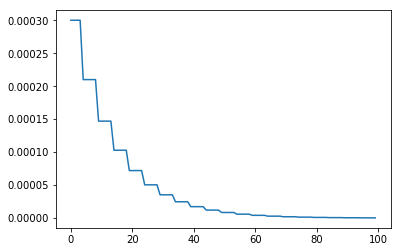

In [14]:
lr = []
for i in range(100):
    lr.append(step_decay(i))
plt.plot(np.arange(100), lr)

In [15]:
score_arr = []

Replace top layer of DenseNet with a FC layer (1024) with batch normalization and ReLU and a FC layer (128). Train with all layers as learnable for 50 epochs with learning rate decay 1e-6.

In [16]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [17]:
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7775235341860272509
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 3580690432
locality {
  bus_id: 1
}
incarnation: 8672994543831254245
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0"
]


In [18]:
# with tf.device('/cpu:0'):
# https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
i = 0
image_dim = (224, 224, 3)
base_model = densenet.DenseNetImageNet121(image_dim)

Weights for the model were loaded successfully


In [19]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 112, 112, 64)  9408        input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 112, 112, 64)  256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [20]:
# test = Sequential()
# new_input = Input(input_shape=(128,64,3), name='new_input')
# test.add(input_1)
# test.compile(loss='categorical_crossentropy',
#               optimizer=Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
#               metrics=['accuracy'])

In [21]:
new_input = Input(shape=(128,64,3), name='new_input')

In [22]:
base_model.outputs = [base_model.layers[-2].output]
base_model.layers[-1].outbound_nodes = []

In [23]:
# https://datascience.stackexchange.com/questions/21610/prepending-input-layer-to-pre-trained-model
x = base_model.outputs[0] # (new_input)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128)(x)

pre_trinet = Model(inputs=base_model.input, outputs=predictions)

pre_trinet.compile(loss=triplet_loss, optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [24]:
trinet = Model(inputs=new_input, outputs=pre_trinet(new_input))
trinet.compile(loss=triplet_loss, optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [25]:
for layer in trinet.layers:
    layer.trainable = True

In [26]:
trinet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
new_input (InputLayer)       (None, 128, 64, 3)        0         
_________________________________________________________________
model_1 (Model)              (None, 128)               8222400   
Total params: 8,222,400
Trainable params: 8,136,704
Non-trainable params: 85,696
_________________________________________________________________


In [16]:
trinet = load_model('/home/albert/github/tensorflow/test_triplet_5k_margin_0.5.h5', 
                    custom_objects={'triplet_loss':triplet_loss})

In [20]:
score_arr = []

for i in range(4):
    epochs = 50
    trinet.fit_generator(output_batch_generator(train_files, labels), 
                     steps_per_epoch=100, 
                     epochs=epochs,
                        callbacks=[history])

    all_embeddings = []
    all_identities = []
    for idt in train_files.keys():
        for f in train_files[idt]:
            img = misc.imread(f)
            predict = trinet.predict(img.reshape(1, 128, 64, 3))
            all_embeddings.append(predict)
            all_identities.append(idt)

    i = 0
    score_arr.append([])
    for x in range(3):
        score = evaluate_rank(trinet, 20, all_embeddings, all_identities, test_iter=1000)
        print score
        score_arr[i].append(score)
    i += 1
    
    model_file = 'test_triplet_%dk_margin_1.0.h5' % ((2 + i) * 5)
    trinet.save('/home/albert/github/tensorflow/%s' % model_file)

Epoch 1/50
100/100 [==============================] - 73s - loss: -3674986060.8000    
Epoch 2/50
100/100 [==============================] - 67s - loss: -3800014796.8000    
Epoch 3/50
100/100 [==============================] - 66s - loss: -3922372305.9200    
Epoch 4/50
100/100 [==============================] - 66s - loss: -4051510272.0000    
Epoch 5/50
100/100 [==============================] - 66s - loss: -4167098956.8000    
Epoch 6/50
100/100 [==============================] - 66s - loss: -4288283609.6000    
Epoch 7/50
100/100 [==============================] - 66s - loss: -4430707660.8000    
Epoch 8/50
100/100 [==============================] - 66s - loss: -4546716866.5600    
Epoch 9/50
100/100 [==============================] - 66s - loss: -4676911278.0800    
Epoch 10/50
100/100 [==============================] - 66s - loss: -4804002595.8400    
Epoch 11/50
100/100 [==============================] - 66s - loss: -4950028252.1600    
Epoch 12/50
100/100 [====================

100/100 [==============================] - 65s - loss: -21000884264.9600    
Epoch 44/50
100/100 [==============================] - 65s - loss: -21261945098.2400    
Epoch 45/50
100/100 [==============================] - 65s - loss: -21545962106.8800    
Epoch 46/50
100/100 [==============================] - 66s - loss: -21748549488.6400    
Epoch 47/50
100/100 [==============================] - 65s - loss: -22062898032.6400    
Epoch 48/50
100/100 [==============================] - 66s - loss: -22272064921.6000    
Epoch 49/50
100/100 [==============================] - 65s - loss: -22544645918.7200    
Epoch 50/50
100/100 [==============================] - 66s - loss: -22744793067.5200    
0.327
0.327
0.335
Epoch 1/50
100/100 [==============================] - 67s - loss: -23082128404.4800    
Epoch 2/50
100/100 [==============================] - 67s - loss: -23364979056.6400    
Epoch 3/50
100/100 [==============================] - 65s - loss: -23626563153.9200    
Epoch 4/50
100/100

100/100 [==============================] - 66s - loss: -49768322703.3600    
Epoch 35/50
100/100 [==============================] - 66s - loss: -50170961715.2000    
Epoch 36/50
100/100 [==============================] - 66s - loss: -50491919687.6800    
Epoch 37/50
100/100 [==============================] - 66s - loss: -50857739550.7200    
Epoch 38/50
100/100 [==============================] - 66s - loss: -51283642777.6000    
Epoch 39/50
100/100 [==============================] - 66s - loss: -51718455582.7200    
Epoch 40/50
100/100 [==============================] - 66s - loss: -52038840688.6400    
Epoch 41/50
100/100 [==============================] - 66s - loss: -52438088048.6400    
Epoch 42/50
100/100 [==============================] - 66s - loss: -52854941491.2000    
Epoch 43/50
100/100 [==============================] - 66s - loss: -53120422584.3200    
Epoch 44/50
100/100 [==============================] - 66s - loss: -53323498700.8000    
Epoch 45/50
100/100 [============

In [29]:
model_file = 'test_triplet_5k_margin_1.0.h5'

In [30]:
trinet.save('/home/albert/github/tensorflow/%s' % model_file)

In [19]:
test_model = load_model('/home/albert/github/tensorflow/%s' % model_file, 
                        custom_objects={'triplet_loss':triplet_loss})

In [30]:
import time
all_embeddings = []
all_identities = []
i = 0
start = time.time()
for idt in train_files.keys():
    for f in train_files[idt]:
        img = cv2.resize(misc.imread(f), (224,224))
        predict = trinet.predict(img.reshape(1, 224, 224, 3))
        all_embeddings.append(predict)
        all_identities.append(idt)
print time.time() - start

319.644582033


In [32]:
i = 0
score_arr.append([])
for x in range(3):
    score = evaluate_rank(trinet, 20, all_embeddings, all_identities, test_iter=1000)
    print score
    score_arr[i].append(score)
i += 1

0.674
0.649
0.657


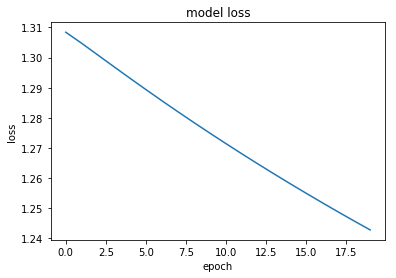

In [36]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [27]:
trinet.save('/home/albert/github/tensorflow/densenet_triplet_%d.h5' % 100)

https://keras.io/getting-started/faq/: use load_model to reinstantiate model.

Train all, lr_decay=1e-6, use log1p